# Plot and visualize MS/MS

In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report, load_global_config

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# go to workingdir/ms-pred
%cd ~/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


# Global configs
Please modify the configs in `configs/iceberg/iceberg_elucidation.yaml` accordingly. If your hostname is ``server1``, create a new entry named ``server1``, and specify all the parameters as shown in the example.

In [3]:
config = load_global_config()
common.plot_utils.set_style()  # Also, set plotting styles

# Leu vs Ile for DiffMS
Fig 1 in DiffMS paper

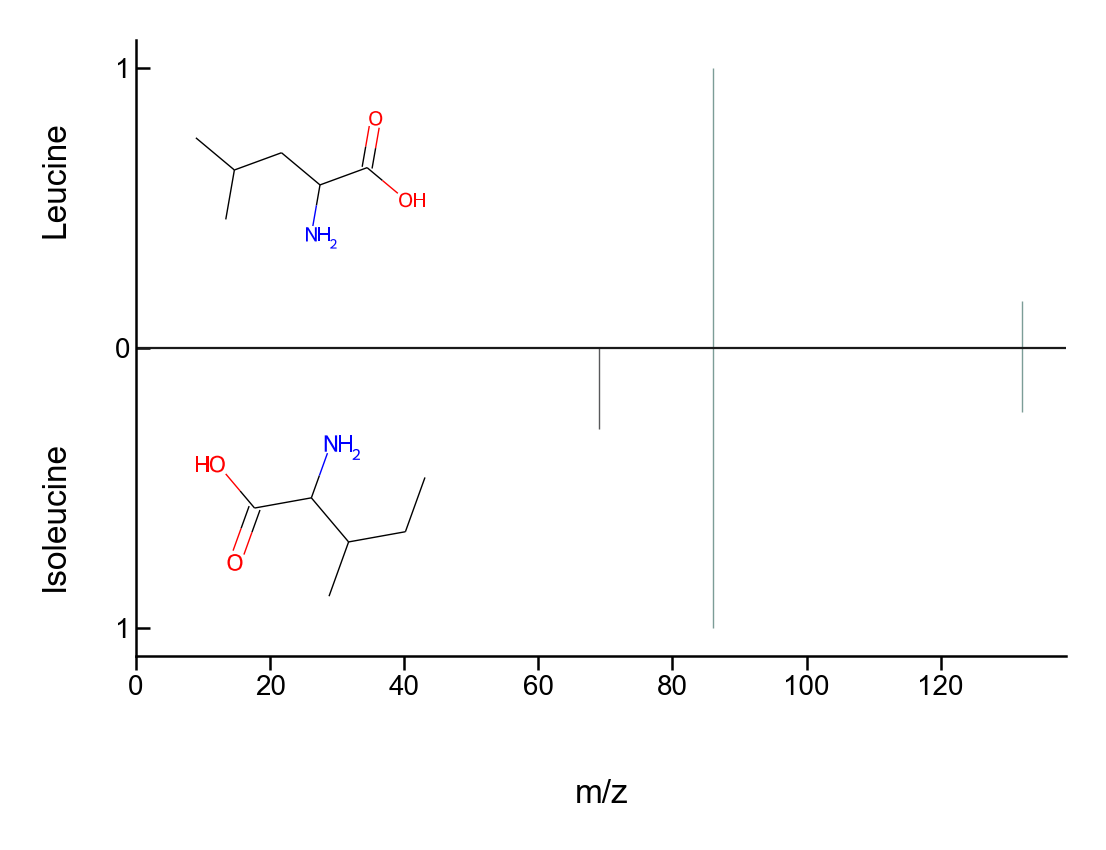

In [4]:
leu_spec = load_real_spec('nist_1250935', 'nist')
isoleu_spec = load_real_spec('nist_1188546', 'nist')

plt.figure(figsize=(3, 2), dpi=400)
ax = plt.gca()
common.plot_compare_ms(leu_spec['13'], isoleu_spec['13'], 'Leucine', 'Isoleucine', ax=ax, ppm=50)
# plt.savefig('leu-ile.pdf')
common.plot_mol_as_vector(Chem.MolFromSmiles('CC(C)CC(N)C(=O)O'), ax=ax, offset=(130/5, 0.6), zoom=0.003)
common.plot_mol_as_vector(Chem.MolFromSmiles('CCC(C)C(N)C(=O)O'), ax=ax, offset=(130/5, -0.6), zoom=0.003)

In [5]:
# Only show peak predictions
def visual_preds(pred_smi, colli_energies=[10, 20, 30, 40, 50], nce=False, merge_ces=False, explain_npeaks=0, name="", **kwargs):
    _config = copy.deepcopy(config)
    _config['nce'] = nce  # use nce for collision energy
    _config['merge_spec'] = merge_ces # merge spec for visualization
    for k, v in kwargs.items():
        _config[k] = v

    # Get candidates
    smiles = [pred_smi]

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, colli_energies, **_config)

    # Visualize and explain peaks
    if merge_ces:
        fig = plt.figure(figsize=(1.5, .8), dpi=400)
        axes = plt.gca()
    else:
        fig, axes = plt.subplots(len(colli_energies), 1, figsize=(1.5, .5 * len(colli_energies)), dpi=400)

    explain_peaks(result_path, None, pmz, pred_smi, num_peaks=explain_npeaks, axes=axes, save_path=f'{name}.pdf', **_config)


In [6]:
# Show peak predictions + experiment spectrum matching
def visual_preds_compare(pred_smi, exp_spec_path, colli_energies=[10, 20, 30, 40, 50], nce=False, merge_ces=False, explain_npeaks=0, name="", real_spec_type='ms', axes=None, **kwargs):
    _config = copy.deepcopy(config)
    _config['nce'] = nce  # use nce for collision energy
    _config['merge_spec'] = merge_ces # merge spec for visualization
    for k, v in kwargs.items():
        _config[k] = v

    # Get candidates
    smiles = [pred_smi]

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(smiles, colli_energies, **_config)
    
    topk_results = elucidation_over_candidates(result_path, exp_spec_path, precursor_mass=pmz, real_spec_type=real_spec_type, **_config)
    entropy_dist = topk_results[0][1]

    # Visualize and explain peaks
    if axes is None:
        if merge_ces:
            fig = plt.figure(figsize=(1.5, .85), dpi=400)
            axes = plt.gca()
            axes.set_title(f'Entropy similarity = {1-entropy_dist:.2f}', y=.9)
        else:
            fig, axes = plt.subplots(len(colli_energies), 1, figsize=(1.5, .6 * len(colli_energies)), dpi=400)
    explain_peaks(result_path, exp_spec_path, pmz, pred_smi, num_peaks=explain_npeaks, axes=axes, pmz=pmz, real_spec_type=real_spec_type, display_expmass=False, save_path=f'{name}.pdf' if len(name) > 0 else None, **_config)
    return entropy_dist

In [7]:
def plot_compare_realms(standard_spec, unknown_spec, precursor_mass, standard_spec_type='ms', unknown_spec_type='ms', nce = True, ppm = 20, standard_label='Standard\nintensity', unknown_label='Plasma\nintensity', save_name="", num_annotate_mz=5):

    fig = plt.figure(figsize=(3, 1.5), dpi=400)

    standard_spec = load_real_spec(standard_spec, standard_spec_type, precursor_mass, nce, ppm)
    unknown_spec = load_real_spec(unknown_spec, unknown_spec_type, precursor_mass, nce, ppm)
    standard_spec = common.merge_specs(standard_spec)
    unknown_spec = common.merge_specs(unknown_spec)
    common.plot_compare_ms(unknown_spec['nan'], standard_spec['nan'], unknown_label, standard_label, '', ax=plt.gca(), largest_mz=precursor_mass, ppm=-1, spec1_color='#E9B382', spec2_color='#7B94CC')
    plt.ylim(-1.2, 1.2)
    plt.gca().xaxis.set_label_coords(0.5, -0.15)

    # explain predicted spectrum
    counter = 0
    unknown_spec['nan'][:, 1] = unknown_spec['nan'][:, 1] / np.max(unknown_spec['nan'][:, 1])
    for spec in sorted(unknown_spec['nan'], key=lambda x: x[1], reverse=True): # sort by inten
        if counter >= num_annotate_mz:
            break
        mz, inten = spec
        if inten > 0.2:
            plt.text(mz, inten + 0.05, f'{mz:.4f}', fontsize=5, horizontalalignment='center', color='#58595B')
            counter += 1

    counter = 0
    standard_spec['nan'][:, 1] = standard_spec['nan'][:, 1] / np.max(standard_spec['nan'][:, 1])
    for spec in sorted(standard_spec['nan'], key=lambda x: x[1], reverse=True): # sort by inten
        if counter >= num_annotate_mz:
            break
        mz, inten = spec
        if inten > 0.2:
            plt.text(mz, -inten - 0.05, f'{mz:.4f}', fontsize=5, verticalalignment='top', horizontalalignment='center', color='#58595B')
            counter += 1

    if save_name:
        plt.savefig(f'{save_name}.pdf', bbox_inches='tight')

# Fig1 prediction

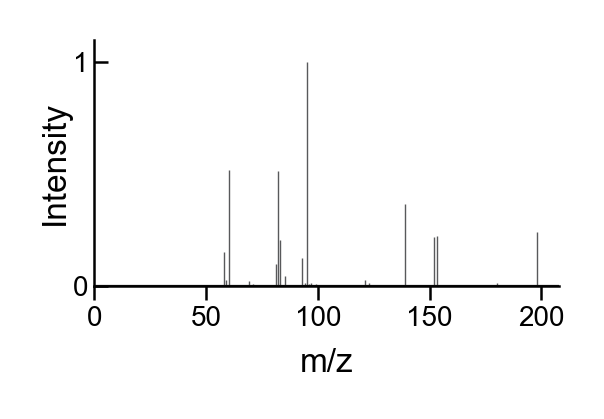

In [8]:
# manually change figsize to (2, 1.5)
visual_preds(r'C[N+](C)(C)[CH](CC1=CN=CN1)C(=O)[O-]', [50], nce=True, explain_npeaks=0, merge_ces=True, name='hercynine', pred_label='Intensity')

## Fig2 collision energies

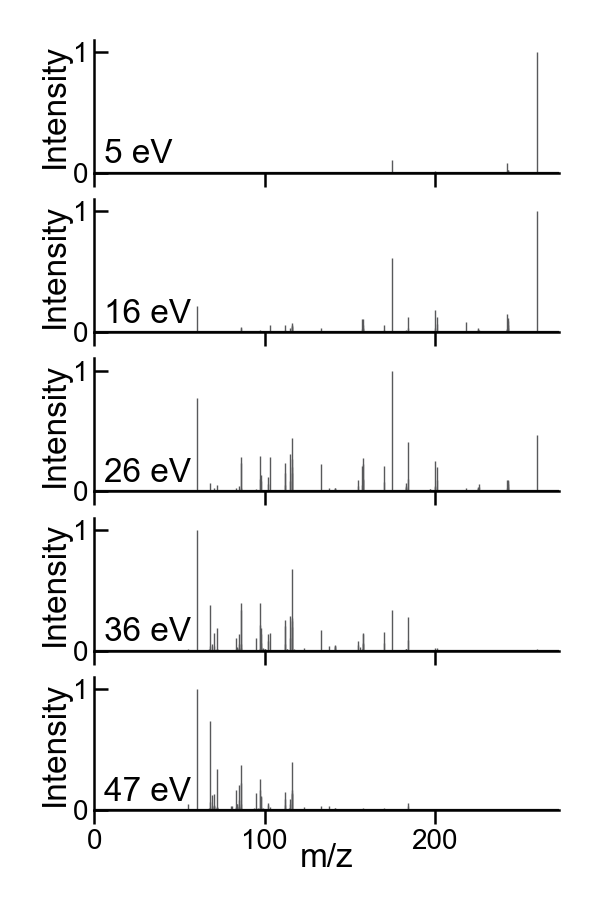

In [9]:
visual_preds(r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N', np.arange(10, 100, 20), nce=True, explain_npeaks=0, name='gaba-arg', pred_label='Intensity')

# Fig 3 GABA-Arg

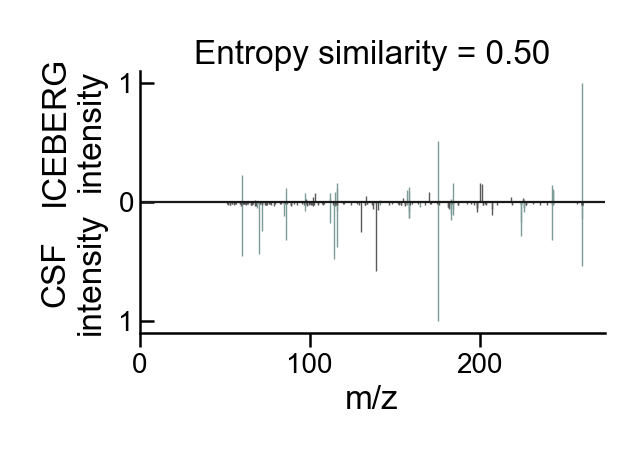

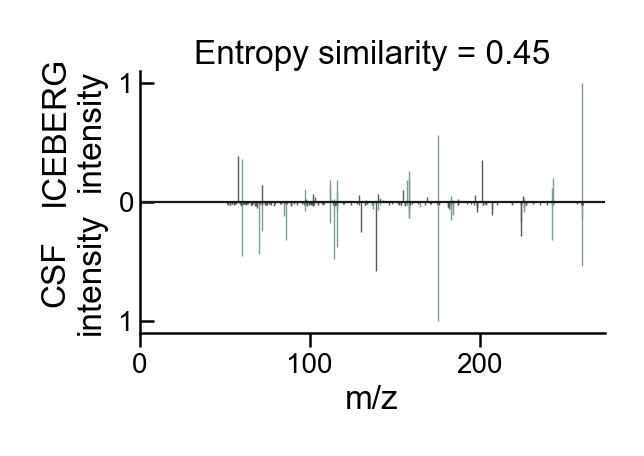

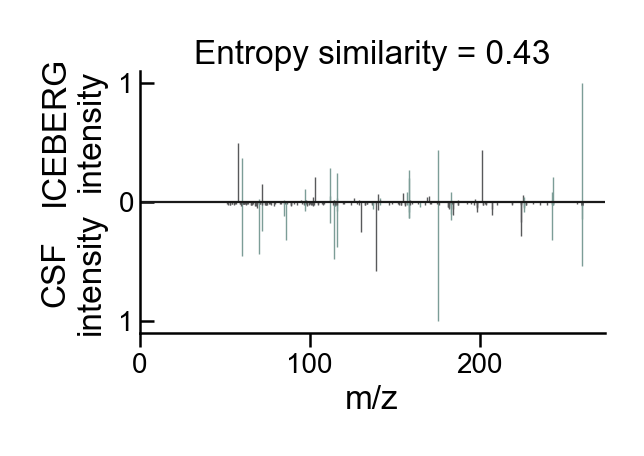

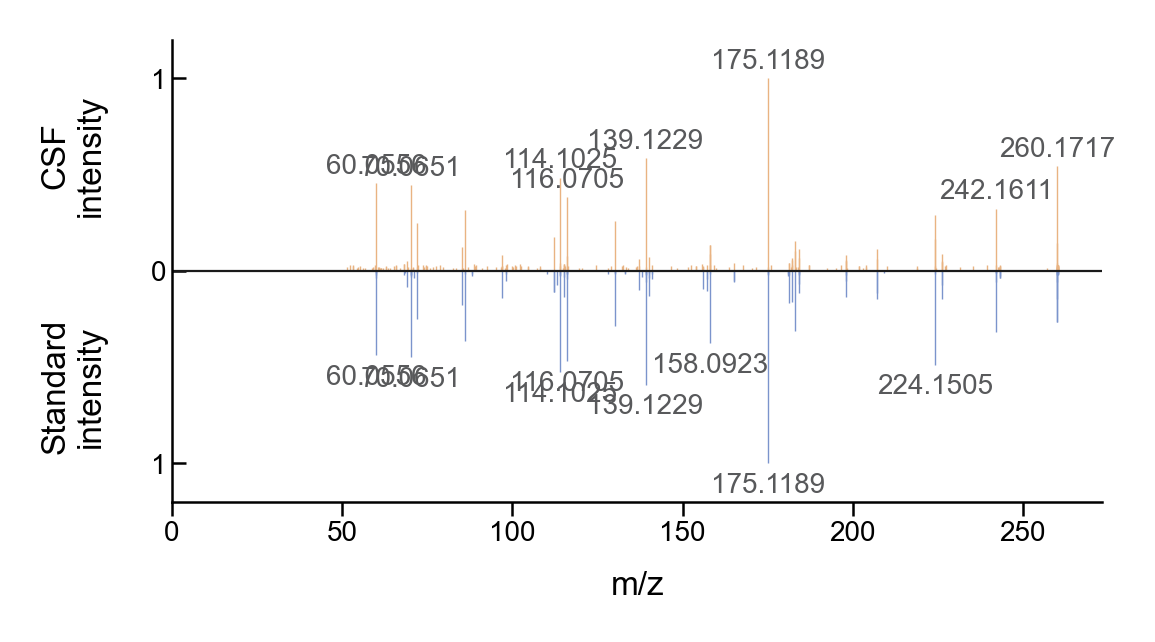

In [10]:
visual_preds_compare(r'C(C[C@@H](C(=O)O)NC(=O)CCCN)CN=C(N)N',
                     f'data/exp_specs/clinical/csf_unknown.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, name='gaba-arg-1', merge_ces=True,
                     pred_label='ICEBERG\nintensity', real_label='CSF\nintensity')
visual_preds_compare(r'CCC(N)C(NC(C(O)=O)CCC/N=C(N)/N)=O',
                     f'data/exp_specs/clinical/csf_unknown.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, name='gaba-arg-2', merge_ces=True,
                     pred_label='ICEBERG\nintensity', real_label='CSF\nintensity')
visual_preds_compare(r'CNC(C)C(NC(C(O)=O)CCC/N=C(N)/N)=O',
                     f'data/exp_specs/clinical/csf_unknown.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, name='gaba-arg-3', merge_ces=True,
                     pred_label='ICEBERG\nintensity', real_label='CSF\nintensity')
plot_compare_realms('data/exp_specs/clinical/gaba_arg_standard.ms', 'data/exp_specs/clinical/csf_unknown.ms', 260.1715, save_name='gaba-arg-standard', unknown_label='CSF\nintensity', num_annotate_mz=8)

# Fig 3 LPC 19:0

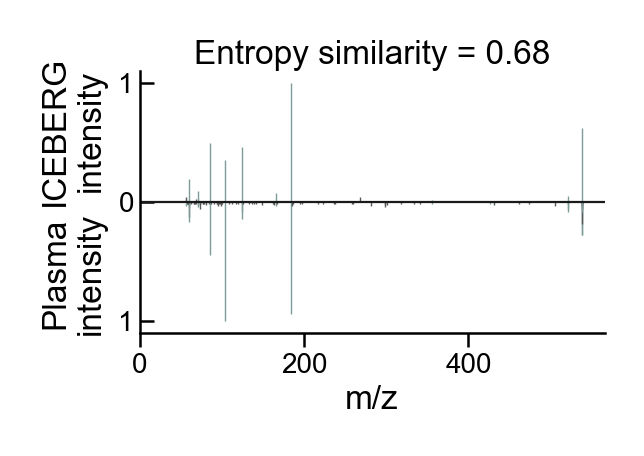

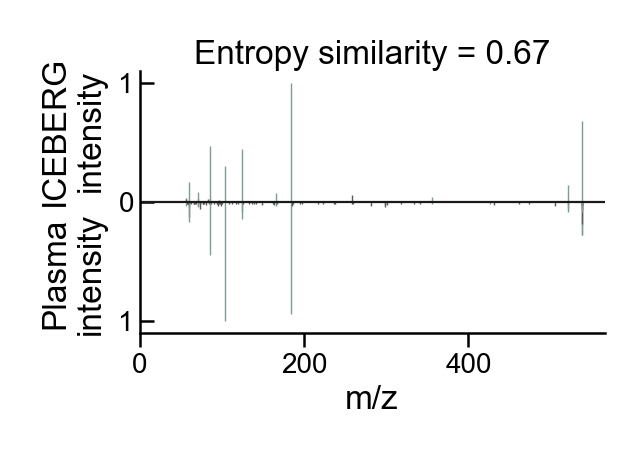

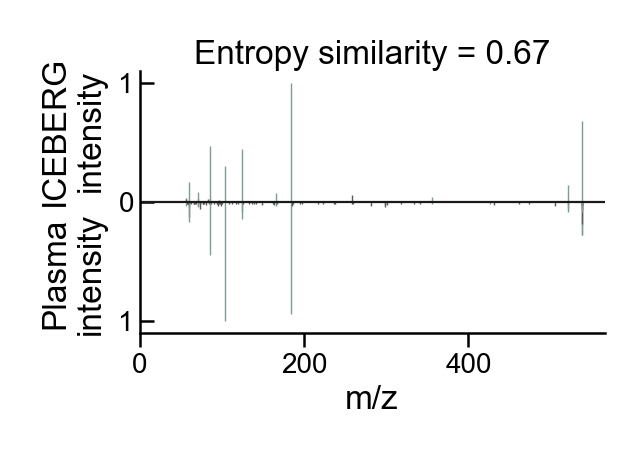

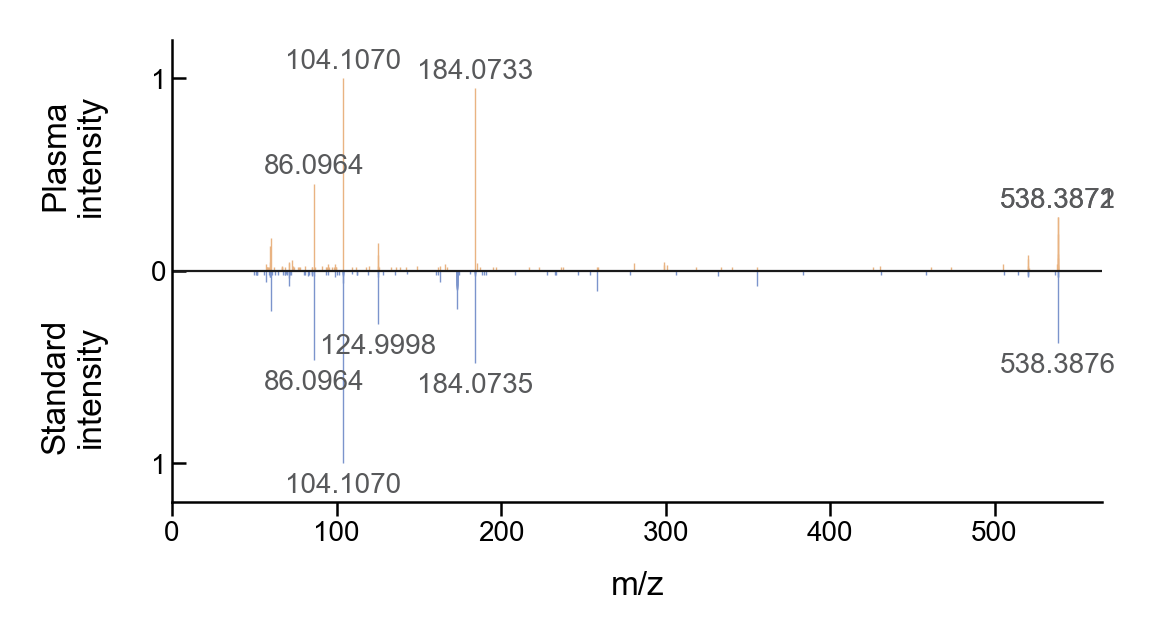

In [11]:
visual_preds_compare(r'C[N+](CCOP([O-])(OCC(O)CC(OCCCCCCCCCCCCCCCCCC)=O)=O)(C)C',
                     f'data/exp_specs/clinical/plasma_unknown_583.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, merge_ces=True, name='lpc-19-0-1',
                     pred_label='ICEBERG\nintensity', real_label='Plasma\nintensity')
visual_preds_compare(r'C[N+](CCOP([O-])(OCC(O)COC(CCCCCCCCCCCCCCCCCC)=O)=O)(C)C',
                     f'data/exp_specs/clinical/plasma_unknown_583.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, merge_ces=True, name='lpc-19-0-2',
                     pred_label='ICEBERG\nintensity', real_label='Plasma\nintensity')
visual_preds_compare(r'C[N+](CCOP([O-])(OCC(O)COC(CCCCCCCCCCCCCCCCCC)=O)=O)(C)C',
                     f'data/exp_specs/clinical/plasma_unknown_583.ms',
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, merge_ces=True, name='lpc-19-0-3',
                     pred_label='ICEBERG\nintensity', real_label='Plasma\nintensity')
plot_compare_realms('data/exp_specs/clinical/lpc19-0_standard.ms', 'data/exp_specs/clinical/plasma_unknown_583.ms', 538.3873, save_name='lpc-standard')

# Fig 3 Hercynine
separated collision energies

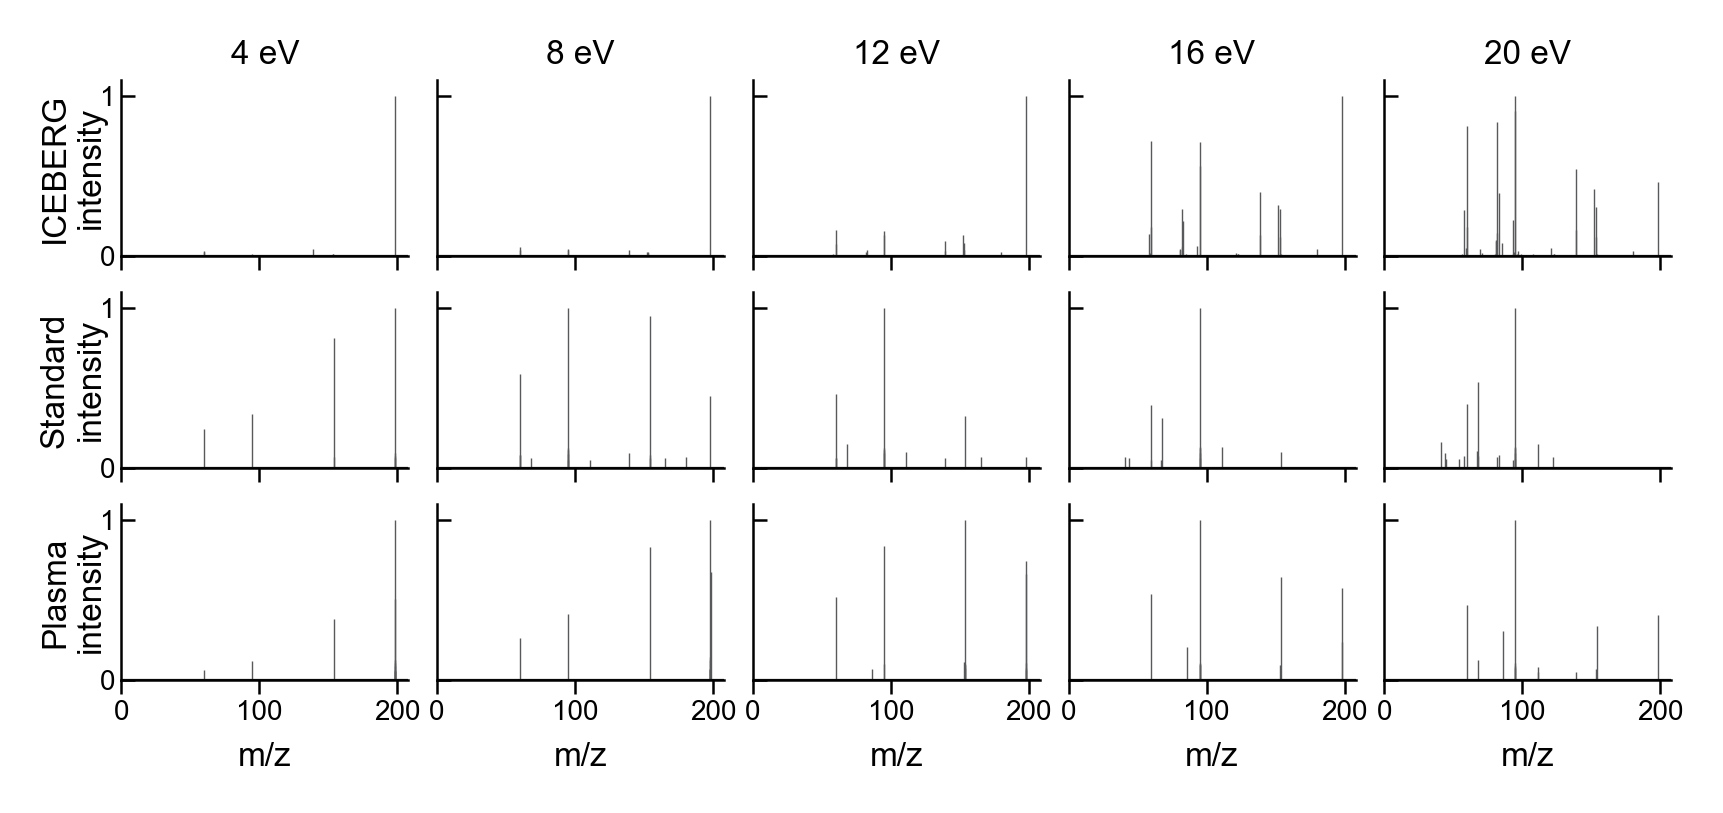

In [12]:
_config = copy.deepcopy(config)
_config['nce'] = True  # use nce for collision energy
_config['merge_spec'] = False # merge spec for visualization
colli_energies = np.arange(10, 51, 10)
smiles = r'C[N+](C)(C)[CH](CC1=CN=CN1)C(=O)[O-]'

fig, axes = plt.subplots(3, len(colli_energies), figsize=(1. * len(colli_energies), .65 * 3), dpi=400)

# Run ICEBERG to predict spectra
result_path, pmz = iceberg_prediction([smiles], colli_energies, **_config)

# visualize prediction
_ = explain_peaks(result_path, None, pmz, smiles, num_peaks=0, axes=axes[0], pred_label='ICEBERG\nintensity', display_ce=False, **_config)
for idx, (nce, ax) in enumerate(zip(colli_energies, axes[0])):
    if idx > 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_xticklabels([])
    ax.set_title(f'{common.nce_to_ev(str(nce.item()), pmz)} eV', y=0.9)

standard_spec = load_real_spec('data/exp_specs/clinical/hercynine_standard.ms', 'ms', nce=True)
for idx, (nce, ax) in enumerate(zip(colli_energies, axes[1])):
    ev_key = common.nce_to_ev(str(nce.item()), pmz)
    common.plot_ms(standard_spec[ev_key], ax=ax, spec_name='Standard\nintensity', largest_mz=pmz)
    if idx > 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.set_xlabel("")
    ax.set_xticklabels([])

# detected MS/MS feature
feature_spec = load_real_spec('data/exp_specs/clinical/plasma_unknown_198.ms', 'ms', nce=True)
for idx, (nce, ax) in enumerate(zip(colli_energies, axes[2])):
    ev_key = common.nce_to_ev(str(nce.item()), pmz)
    common.plot_ms(feature_spec[ev_key], ax=ax, spec_name='Plasma\nintensity', largest_mz=pmz)
    if idx > 0:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.xaxis.set_label_coords(0.5, -0.35)

plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig('hercynine.pdf', bbox_inches='tight')

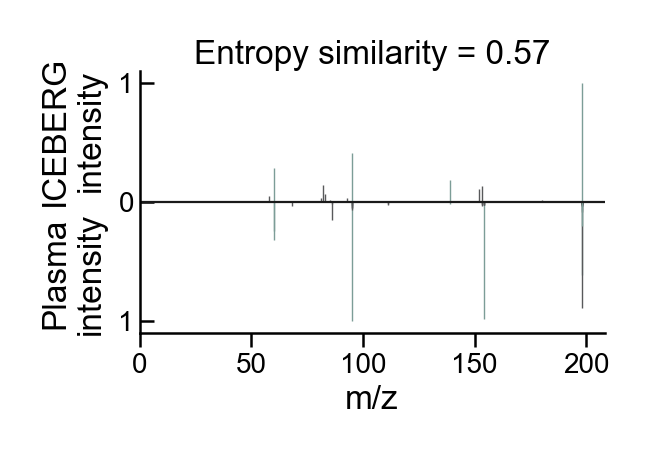

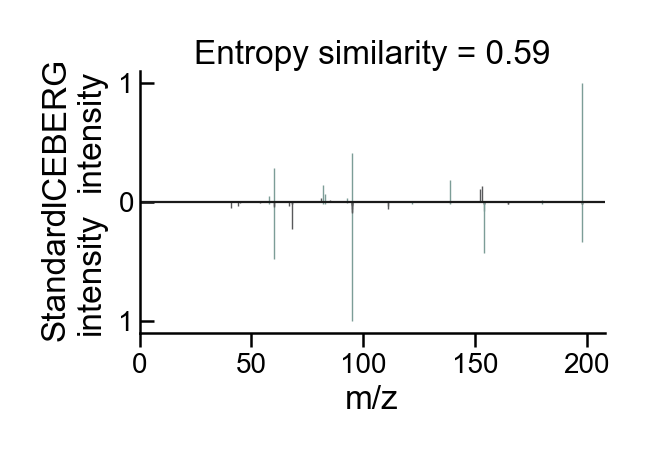

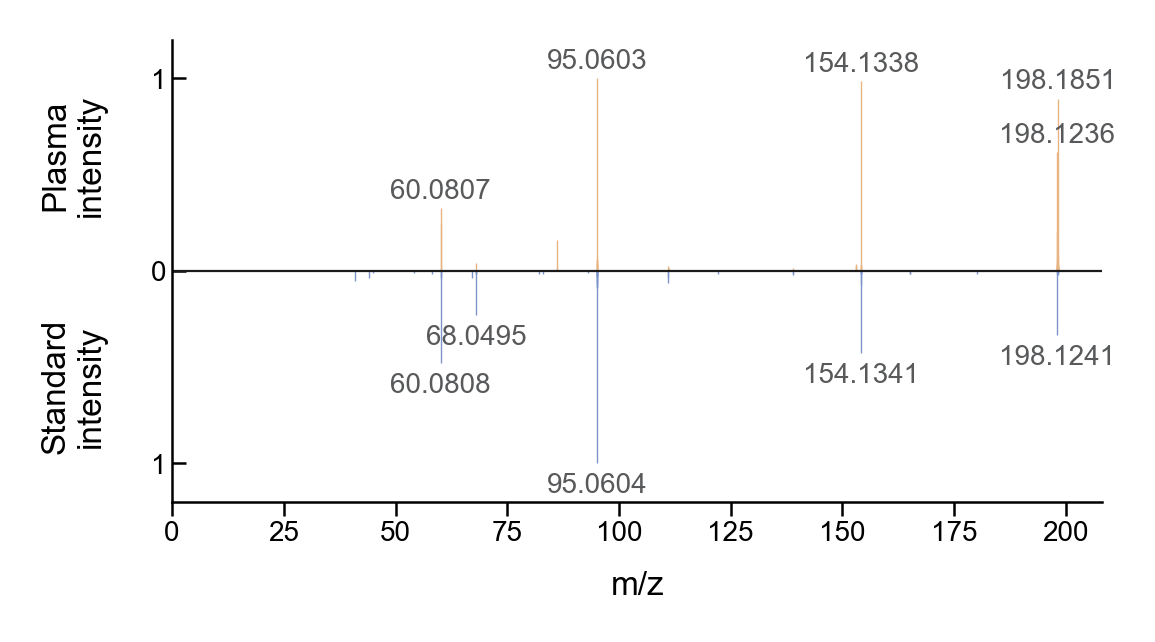

In [13]:
visual_preds_compare(r'C[N+](C)(C)[CH](CC1=CN=CN1)C(=O)[O-]',
                     f'data/exp_specs/clinical/plasma_unknown_198.ms',  # compare to unknown
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, merge_ces=True, name='',
                     pred_label='ICEBERG\nintensity', real_label='Plasma\nintensity')
visual_preds_compare(r'C[N+](C)(C)[CH](CC1=CN=CN1)C(=O)[O-]',
                     f'data/exp_specs/clinical/hercynine_standard.ms',  # compare to standard
                     np.arange(10, 51, 10), nce=True, explain_npeaks=0, merge_ces=True, name='',
                     pred_label='ICEBERG\nintensity', real_label='Standard\nintensity')
plot_compare_realms('data/exp_specs/clinical/hercynine_standard.ms', 'data/exp_specs/clinical/plasma_unknown_198.ms', 198.1237, save_name='hercynine-standard')

# Fig 3 Thiophanate-methyl TP

4it [00:00, 4193.26it/s]


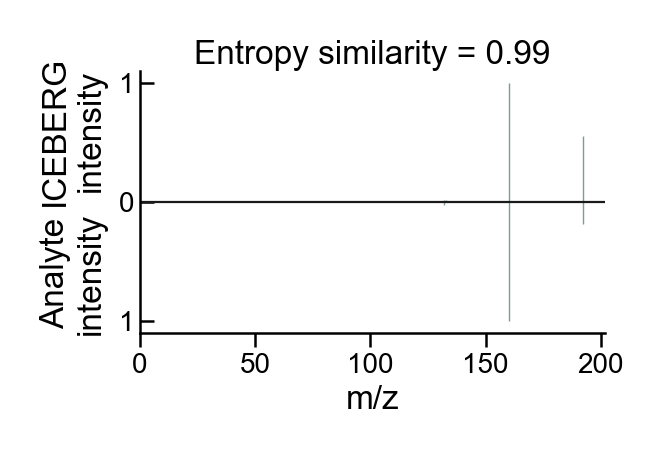

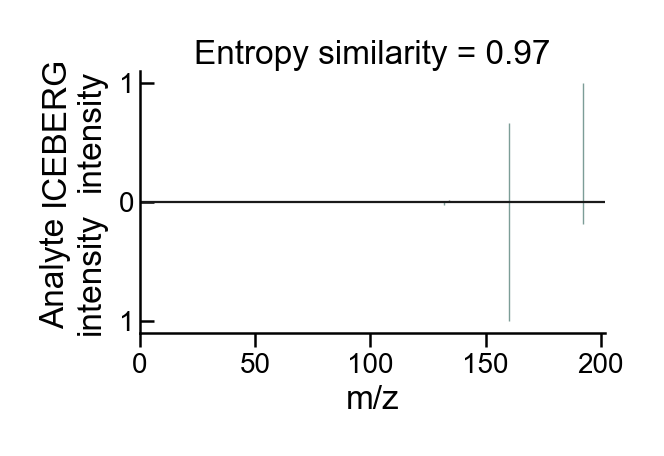

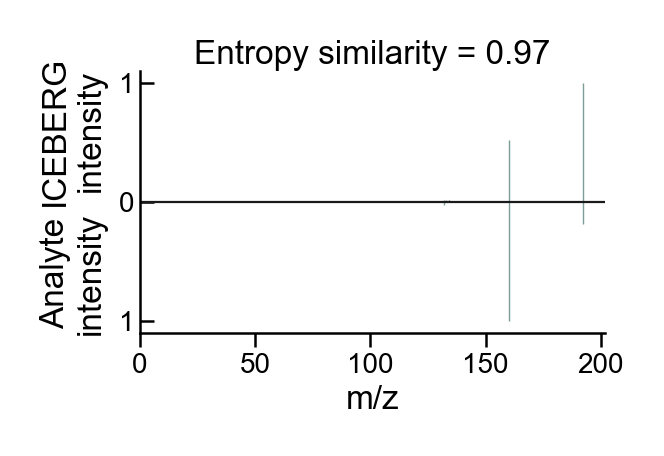

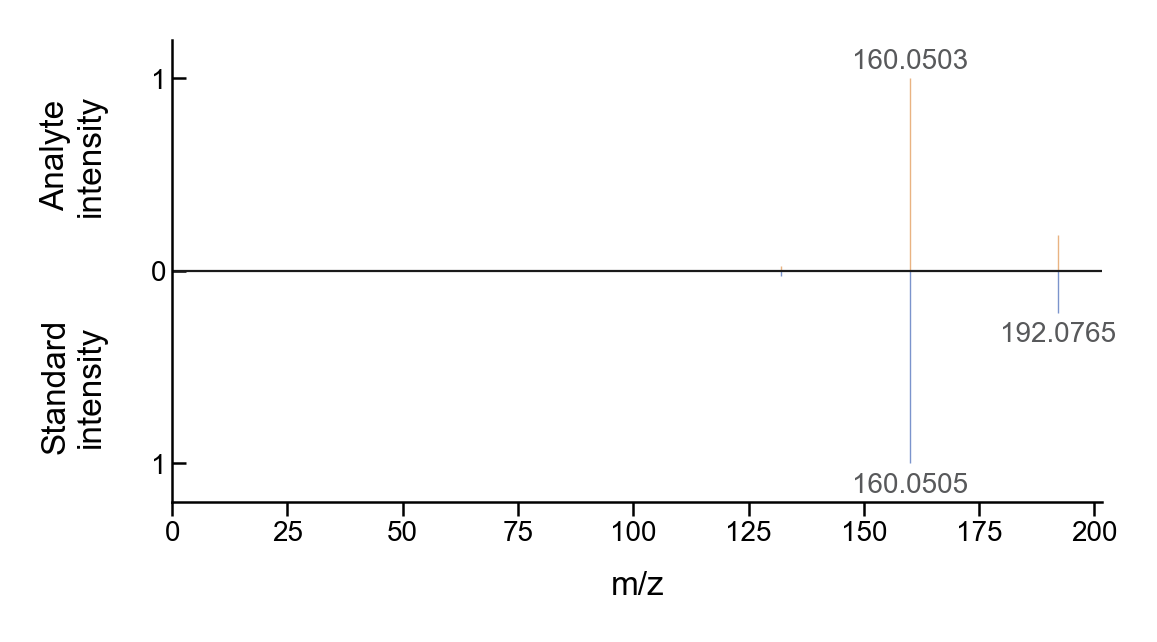

In [14]:
inp_mgf = 'data/exp_specs/pesticide/interested_unknown.mgf'

all_specs = common.parse_spectra_mgf(inp_mgf)
feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if (entry[0]['MSLEVEL'] == '2' and entry[0]['FEATURE_ID'] == '919')
    # 919 is the feature_id of interest
}
spec = {'nan': feat_id_to_specs['919']}

visual_preds_compare(r'COC(=O)N=c1[nH]c2ccccc2[nH]1', spec,
                     [30, 40, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='th-tp-1',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

visual_preds_compare(r'COC(=O)Nc1cn2ccccc2n1', spec,
                     [30, 40, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='th-tp-2',
                    pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

visual_preds_compare(r'COC(=O)Nc1ccn2ccnc2c1', spec,
                     [30, 40, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='th-tp-3',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

standard_spec = {'nan': np.array([
[91.906895, 0.532687],
[92.049454, 0.532985],
[105.044734, 0.603041],
[132.055526, 2.573217],
[133.063659, 0.768588],
[135.055314, 0.613373],
[160.042901, 0.480877],
[160.05048, 100],
[160.064025, 0.488363],
[192.076527, 21.726437],
[192.085673, 0.547121],
[192.137809, 0.450407]])}

plot_compare_realms(standard_spec, spec, 192.0766, standard_spec_type='raw', unknown_spec_type='raw', unknown_label='Analyte\nintensity',  save_name='carbendazim-standard')


# Fig 4 pooled C-N coupling reaction

28076it [00:00, 35836.18it/s]


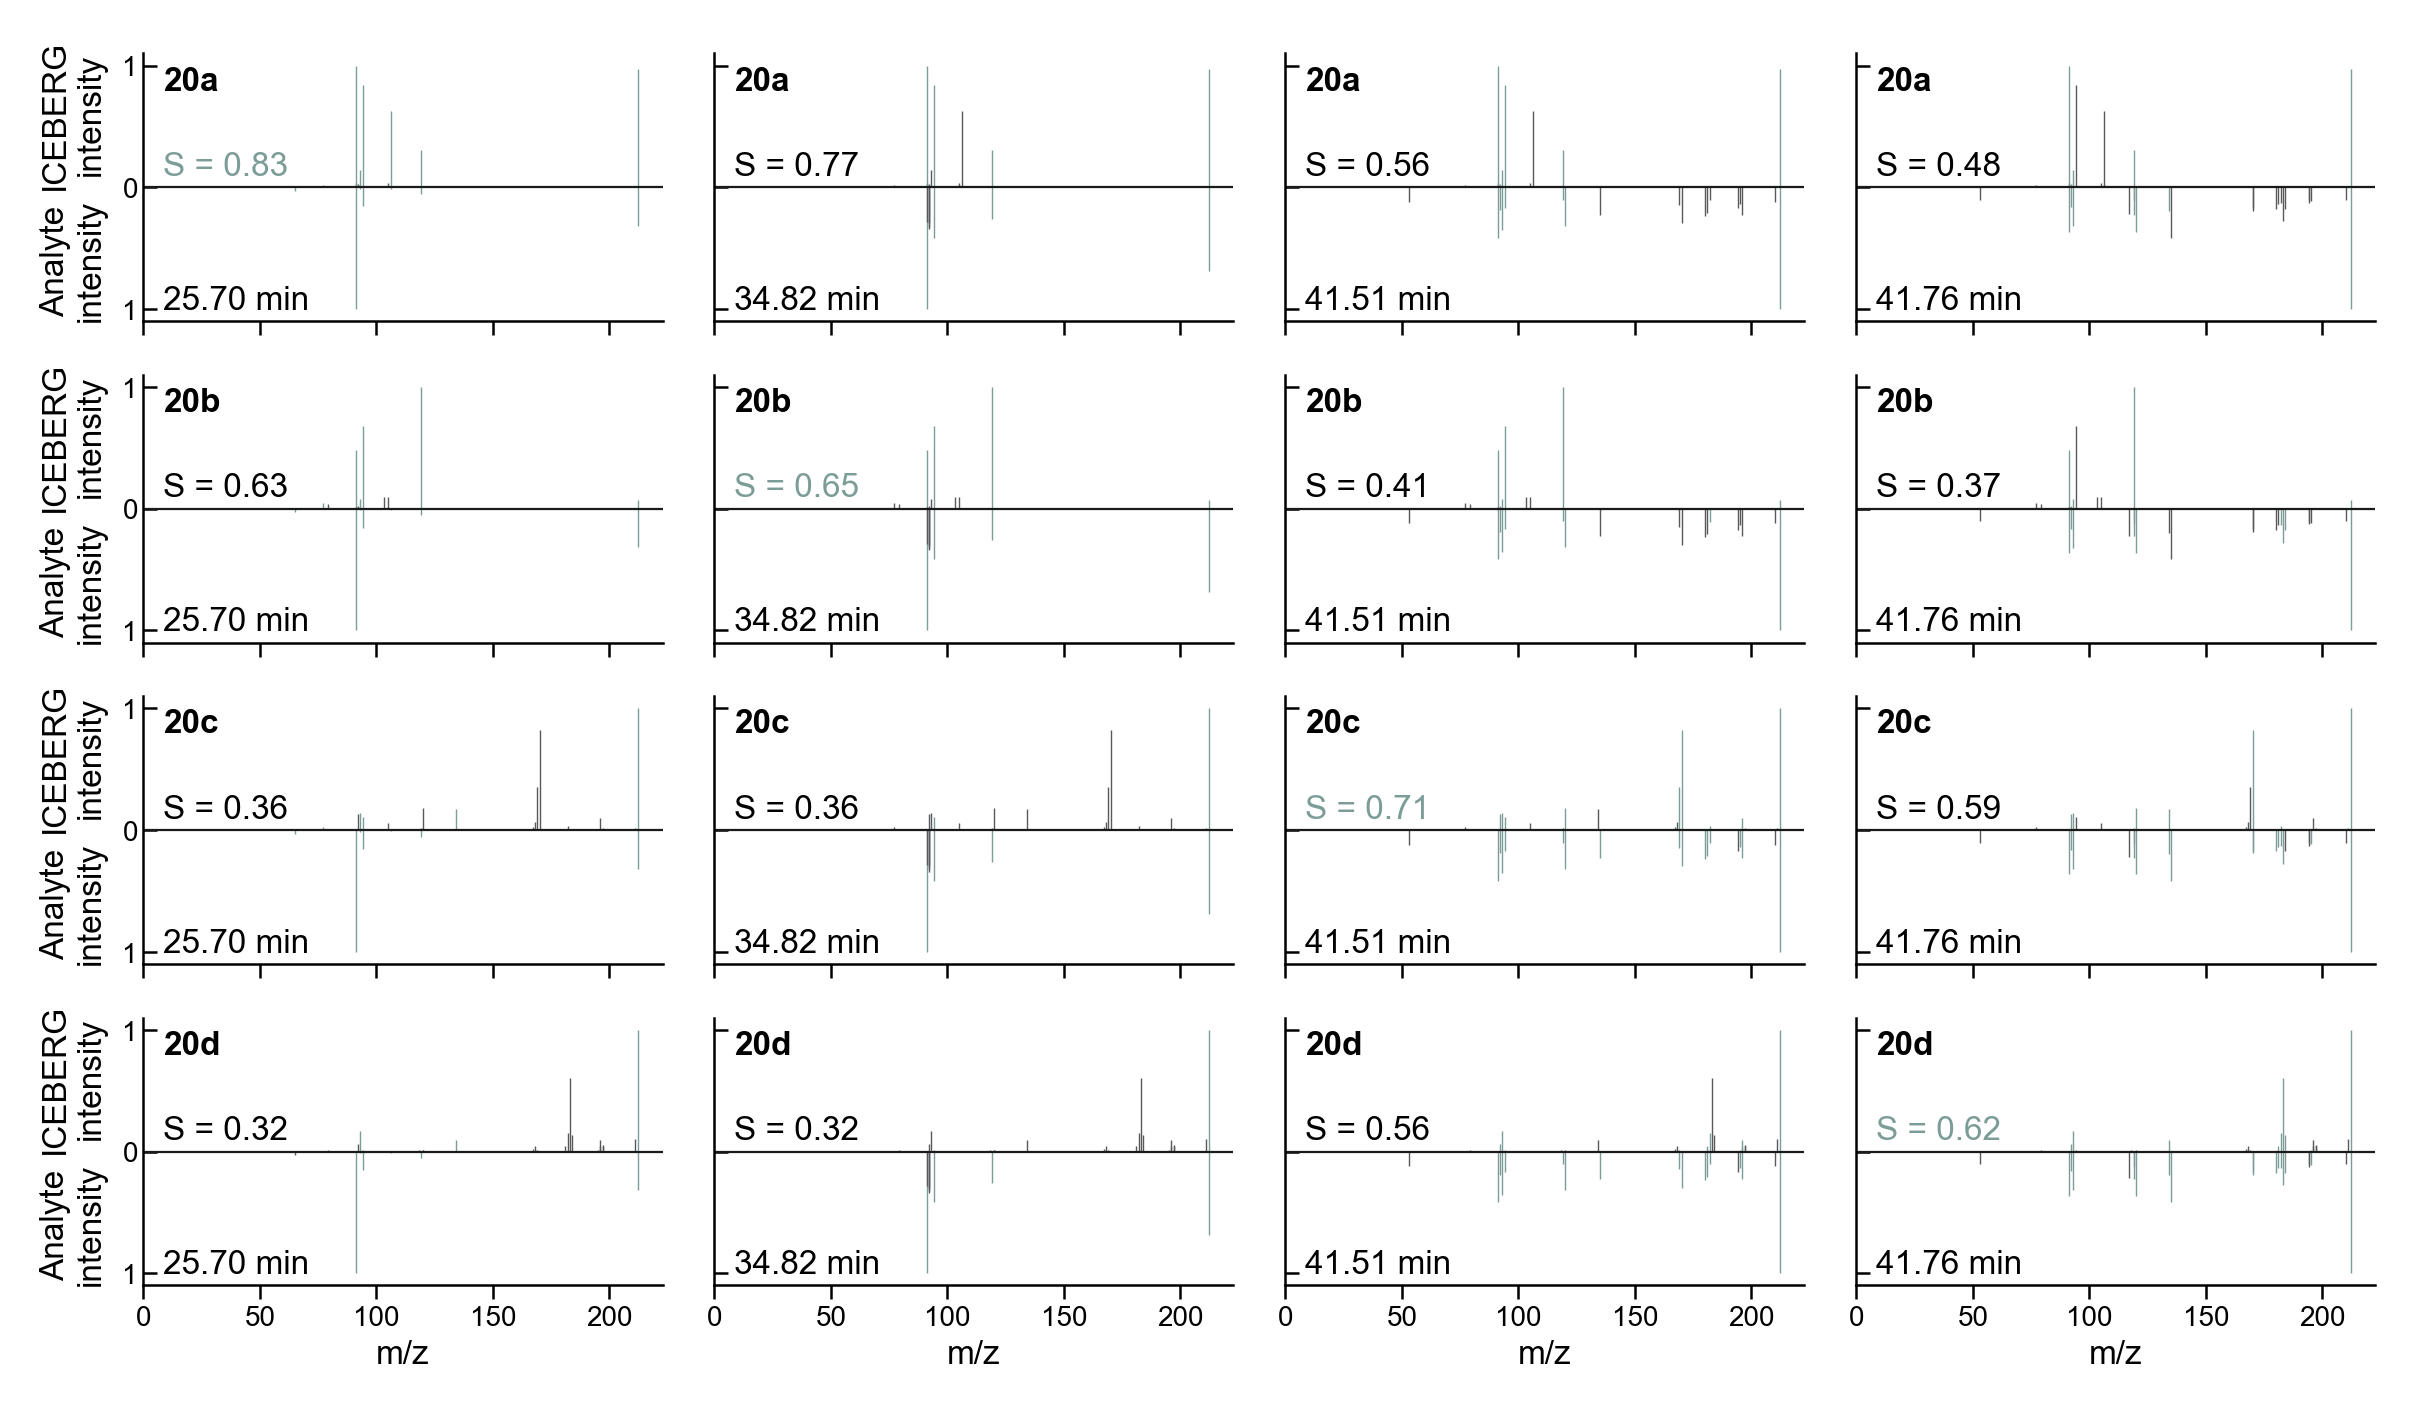

In [15]:
import pygmtools as pygm

all_smiles = ['C%12(CCCNC%13=CC=CC=C%13)=CC=CC=C%12', 'CCC(NC6=CC=CC=C6)C7=CC=CC=C7', 'CC(C)C%10=C(NC%11=CC=CC=C%11)C=CC=C%10', 'CCC8=CC=CC(C)=C8NC9=CC=CC=C9']
all_feat_ids = ['5878',]
inp_mgf = 'data/exp_specs/cn_coupling/all_nitro_and_iodo.mgf'

all_specs = common.parse_spectra_mgf(inp_mgf)
feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if (entry[0]['MSLEVEL'] == '2' and entry[0]['FEATURE_ID'] in all_feat_ids)
}

# manually merge specs, the following scans are obtained by manually parsing the raw data
all_mzs = [
    [91.0544, 91.9061, 91.9082, 100.9753, 115.4284, 129.7684, 204.3770, 212.1438],
    [70.2320, 91.0543, 91.9053, 91.9083, 125.3397,
        128.5127, 129.6969, 188.6784, 188.7928, 212.1440],
    [62.8332, 91.0543, 221.2854],
    [91.0544, 94.0652, 101.5873, 106.8550, 114.1071,
        139.5107, 145.0307, 212.1441, 230.8916, 234.3647],
    [81.7754, 91.0544, 91.0571, 91.9074, 94.0652, 102.3442, 119.0858, 212.1435]]
all_intens = [
    [1.8E6, 2.5E5, 2.7E5, 1.9E5, 1.9E5, 1.9E5, 2.0E5, 5.2E5],
    [2.0E5, 7.0E5, 4.3E5, 5.7E5, 1.9E5, 2.1E5, 2.0E5, 2.0E5, 2.2E5, 2.1E5],
    [2.4E5, 7.4E5, 2.8E5],
    [2.2E6, 4.5E5, 2.0E5, 1.9E5, 1.9E5, 2.0E5, 2.0E5, 1.0E6, 2.1E5, 1.9E5],
    [2.0E5, 4.9E6, 4.0E5, 5.1E5, 8.4E5, 2.1E5, 3.3E5, 2.3E6]
]

all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(0, 5)]
# spec_9622 = common.merge_specs(all_peaks, merge_method='max')['nan']
spec_9622 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_9622 = common.max_inten_spec(spec_9622, inten_thresh=0.25)

all_mzs = [
[65.0387,74.6598,91.0543,91.9062,92.0495,93.0574,94.0652,101.0682,101.5591,106.0652,106.8943,109.4952,113.1854,117.7091,119.0855,120.0808,126.3508,135.1041,160.8612,169.0889,170.0965,180.0809,181.0886,194.0963,195.1040,196.1122,200.5151,212.1434],
[51.1133,51.7257,52.2547,53.0351,54.8757,56.2296,57.4192,57.7760,58.4713,58.6909,58.8861,62.1809,65.0386,67.2169,67.9829,78.7928,80.8177,83.7624,91.0543,91.9073,92.0496,93.0543,93.0574,94.0653,103.0545,106.0652,120.0809,120.0855,131.0731,134.0964,135.1042,150.6048,153.0700,155.4503,167.0737,168.0809,169.0885,170.0964,171.3577,180.0808,181.0886,182.0968,193.9541,194.0965,195.1044,196.1121,197.1199,208.6856,210.1277,212.1434,212.1643],
[51.0232,53.0350,65.0385,70.5860,72.6995,79.0542,82.9689,89.3041,91.0513,91.0543,91.9061,91.9091,92.0495,93.0573,94.0650,106.0650,120.0761,120.0808,134.0963,135.1042,137.9546,145.5597,149.8257,153.0697,168.0804,168.3178,169.0885,170.0963,180.0808,181.0885,182.0966,191.0895,194.0962,195.1043,196.1121,197.1197,210.1275,212.1433,212.6767],
[53.0351,54.5088,65.0387,91.0543,91.9076,92.0467,92.0496,93.0543,93.0574,94.0651,95.2928,106.0651,120.0809,123.1999,134.0965,135.1043,136.7619,137.9254,143.0854,153.0695,157.7873,168.0806,169.0888,170.0964,180.0808,181.0888,182.0966,194.0966,195.1045,196.1121,197.1207,210.1278,212.1320,212.1434],
[53.0351,65.0385,91.0543,91.9053,91.9083,92.0496,93.0574,94.0651,103.0545,106.0651,119.0857,120.0809,127.7293,131.0731,134.0965,135.1042,153.0697,165.4003,168.0809,169.0886,170.0964,180.0807,181.0886,182.0964,183.1041,194.0966,195.1044,196.1121,197.1197,210.1282,212.1434],
[53.0350,67.9866,71.9841,89.5372,91.0517,91.0544,92.0495,93.0574,103.0545,117.0698,117.3706,119.0855,120.0808,124.9924,134.0964,135.1042,137.3235,140.1042,168.0809,169.0887,170.0962,180.0808,181.0882,182.0966,183.1040,184.1120,194.0964,195.1041,196.1120,210.1279,212.1320,212.1434],
[53.0350,65.0386,79.0542,91.0543,91.9057,91.9085,92.0496,93.0574,93.0602,93.0698,103.0541,110.2593,117.0699,119.0731,119.0856,120.0808,123.5046,134.0963,135.1042,135.1097,169.0884,170.0965,178.9617,180.0807,181.0885,182.0964,183.1043,184.1120,194.0967,195.1043,196.1120,204.8851,210.1272,210.9980,212.1433,233.7700],
[53.0351,65.0385,67.1078,79.0543,91.0543,91.9066,92.0495,93.0547,93.0574,103.0542,104.0620,104.6086,106.0651,115.0541,117.0699,119.0729,119.0856,120.0808,120.0855,126.9029,134.0965,135.1042,142.2281,142.2337,169.0884,170.0966,180.0806,181.0886,182.0964,183.1043,184.1123,194.0964,195.1041,196.1122,197.1203,207.8730,210.1278,212.1433,227.9024],
[53.0351,53.4538,59.8154,65.0386,79.0543,85.1691,91.0543,91.9078,92.0495,92.8562,93.0574,93.0699,98.6425,103.0542,106.0651,115.0541,117.0699,119.0729,119.0856,119.5667,120.0808,120.5405,121.6822,134.0965,135.1042,135.1097,139.9886,153.8650,168.0813,169.0882,170.0965,178.4134,180.0805,181.0884,182.0965,183.1042,184.1123,194.0969,195.1043,196.1122,197.1201,198.8276,210.1277,212.1433]]
all_intens = [
[2.2E5,1.8E5,1.3E7,4.9E5,5.9E5,2.0E6,2.1E6,1.9E5,2.1E5,3.1E5,1.9E5,1.9E5,2.3E5,1.8E5,8.0E5,1.6E6,1.9E5,9.7E5,2.1E5,2.5E5,1.5E6,7.8E5,6.8E5,6.5E5,4.0E5,8.2E5,2.0E5,1.8E7],
[1.7E5,1.8E5,1.6E5,1.1E6,1.8E5,1.6E5,1.8E5,1.5E5,1.6E5,1.8E5,1.5E5,1.8E5,4.8E5,1.7E5,2.0E5,1.9E5,2.0E5,2.0E5,8.6E6,3.0E5,2.7E6,3.9E5,9.4E6,5.6E5,2.4E5,7.1E5,7.5E6,2.5E5,2.0E5,3.9E5,3.9E6,2.2E5,5.2E5,2.1E5,2.5E5,5.9E5,1.6E6,6.6E6,2.1E5,4.1E6,3.3E6,8.4E5,2.1E5,2.2E6,1.4E6,3.8E6,3.1E5,2.2E5,1.1E6,7.5E7,4.6E5],
[2.2E5,5.9E5,4.1E5,2.1E5,2.1E5,2.0E5,1.9E5,1.9E5,3.5E5,7.5E6,5.1E5,3.0E5,2.6E6,7.3E6,2.9E5,6.3E5,2.2E5,6.4E6,6.3E5,3.0E6,2.3E5,1.9E5,2.1E5,5.9E5,5.6E5,2.2E5,9.7E5,5.8E6,3.0E6,2.4E6,5.9E5,2.1E5,2.3E6,9.8E5,2.7E6,3.1E5,9.7E5,4.9E7,2.1E5],
[6.1E5,2.1E5,4.1E5,6.8E6,3.4E5,2.5E5,3.2E6,2.7E5,8.1E6,4.2E5,2.1E5,5.3E5,6.1E6,2.3E5,2.9E5,3.2E6,2.1E5,2.3E5,2.6E5,5.0E5,2.1E5,5.1E5,1.2E6,6.5E6,3.9E6,2.5E6,7.4E5,2.2E6,1.4E6,3.1E6,2.3E5,6.7E5,4.8E5,5.0E7],
[5.5E5,5.4E5,7.3E6,4.3E5,5.2E5,2.6E6,7.7E6,3.6E5,2.3E5,8.3E5,2.2E5,6.4E6,2.3E5,2.3E5,4.3E5,3.8E6,2.6E5,2.2E5,5.7E5,1.6E6,5.3E6,3.8E6,2.9E6,8.9E5,2.5E5,2.2E6,1.3E6,3.2E6,3.2E5,1.1E6,4.6E7],
[3.2E5,2.0E5,2.3E5,2.2E5,3.0E5,3.4E6,1.1E6,2.5E6,2.0E5,5.3E5,2.0E5,7.2E5,2.7E6,2.0E5,7.9E5,3.5E6,2.1E5,1.9E5,2.3E5,4.3E5,1.4E6,1.1E6,7.2E5,4.5E5,1.1E6,6.1E5,6.7E5,3.9E5,1.1E6,4.6E5,3.6E5,3.4E7],
[4.5E5,3.3E5,3.7E5,4.9E6,2.8E5,4.6E5,1.3E6,4.5E6,4.2E5,2.4E5,4.7E5,2.2E5,2.1E6,3.7E5,2.0E6,6.0E6,2.3E5,1.7E6,7.7E6,3.6E5,8.2E5,1.4E6,2.3E5,1.6E6,9.7E5,6.8E5,2.6E6,1.0E6,3.1E5,3.2E5,8.7E5,2.3E5,3.3E5,2.2E5,4.4E7,2.2E5],
[5.0E5,3.2E5,2.1E5,3.1E5,5.8E6,3.5E5,1.3E6,2.9E5,3.6E6,3.6E5,3.0E5,2.2E5,3.9E5,4.8E5,2.4E6,5.7E5,2.5E6,6.5E6,2.4E5,2.1E5,1.5E6,8.3E6,2.0E5,2.1E5,1.1E6,1.4E6,1.5E6,9.0E5,8.5E5,3.6E6,1.0E6,8.2E5,2.9E5,8.2E5,2.7E5,2.0E5,4.6E5,4.4E7,2.5E5],
[5.3E5,1.9E5,2.0E5,4.5E5,2.7E5,2.1E5,6.5E6,2.3E5,1.2E6,2.3E5,5.0E6,3.4E5,1.9E5,3.8E5,2.6E5,3.3E5,2.0E6,6.6E5,2.3E6,2.2E5,6.2E6,2.0E5,1.9E5,1.9E6,8.4E6,2.0E5,2.2E5,2.1E5,2.8E5,1.0E6,1.8E6,2.0E5,1.1E6,1.1E6,7.6E5,3.8E6,1.5E6,5.5E5,6.3E5,1.1E6,4.8E5,2.2E5,5.3E5,4.9E7]
]

all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(0, 2)]
spec_elute1 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_elute1 = common.max_inten_spec(spec_elute1, inten_thresh=0.1)

all_peaks = [(str(i), np.array([[mz, inten] for inten, mz in zip(all_intens[i], all_mzs[i])])) for i in range(7, 9)]
spec_elute2 = common.process_spec_file({"parentmass": 212.1432}, all_peaks, precision=3)
spec_elute2 = common.max_inten_spec(spec_elute2, inten_thresh=0.1)

all_specs = [feat_id_to_specs['5878'], spec_9622, spec_elute1, spec_elute2]

rt_map = {0: 25.70, 1: 34.82, 2: 41.51, 3: 41.76}

# plot with fixed MS2
ent_matrix = np.zeros((len(all_smiles), len(all_specs)))
fig, axes = plt.subplots(len(all_smiles), len(all_specs), figsize=(1.8 * len(all_specs), 1. * len(all_specs)), dpi=400)
for i, j in itertools.product(range(len(all_smiles)), range(len(all_specs))):
    ax = axes[i][j]
    entr_dist = visual_preds_compare(all_smiles[i], {'nan': all_specs[j]}, [30, 45, 60],
                         nce=True, explain_npeaks=0, merge_ces=True, step_collision_energy=True, real_spec_type='raw', axes=ax, ignore_precursor=False,
                         pred_label=f'ICEBERG\nintensity' if j == 0 else "", real_label=f'Analyte\nintensity' if j == 0 else "")
    ent_matrix[i][j] = 1 - entr_dist
    ax.text(212.1432/25, 0.8, f'20{chr(i + ord("a"))}', weight='bold')
    ax.text(212.1432/25, -1, f'{rt_map[j]:.2f} min')
    ax.set_title("")
    if i != len(all_smiles) - 1:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    if j != 0:
        ax.set_yticklabels([])

assignment = pygm.hungarian(ent_matrix)  # find maximal assignment
for i, j in itertools.product(range(len(all_smiles)), range(len(all_specs))):
    ax = axes[i][j]
    ax.text(212.1432/25, 0.1, f'S = {ent_matrix[i][j]:.2f}', color='#7C9D97' if assignment[i][j] else 'black')

plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig('bh_pool-iodo.pdf', bbox_inches='tight')

28076it [00:00, 40064.83it/s]


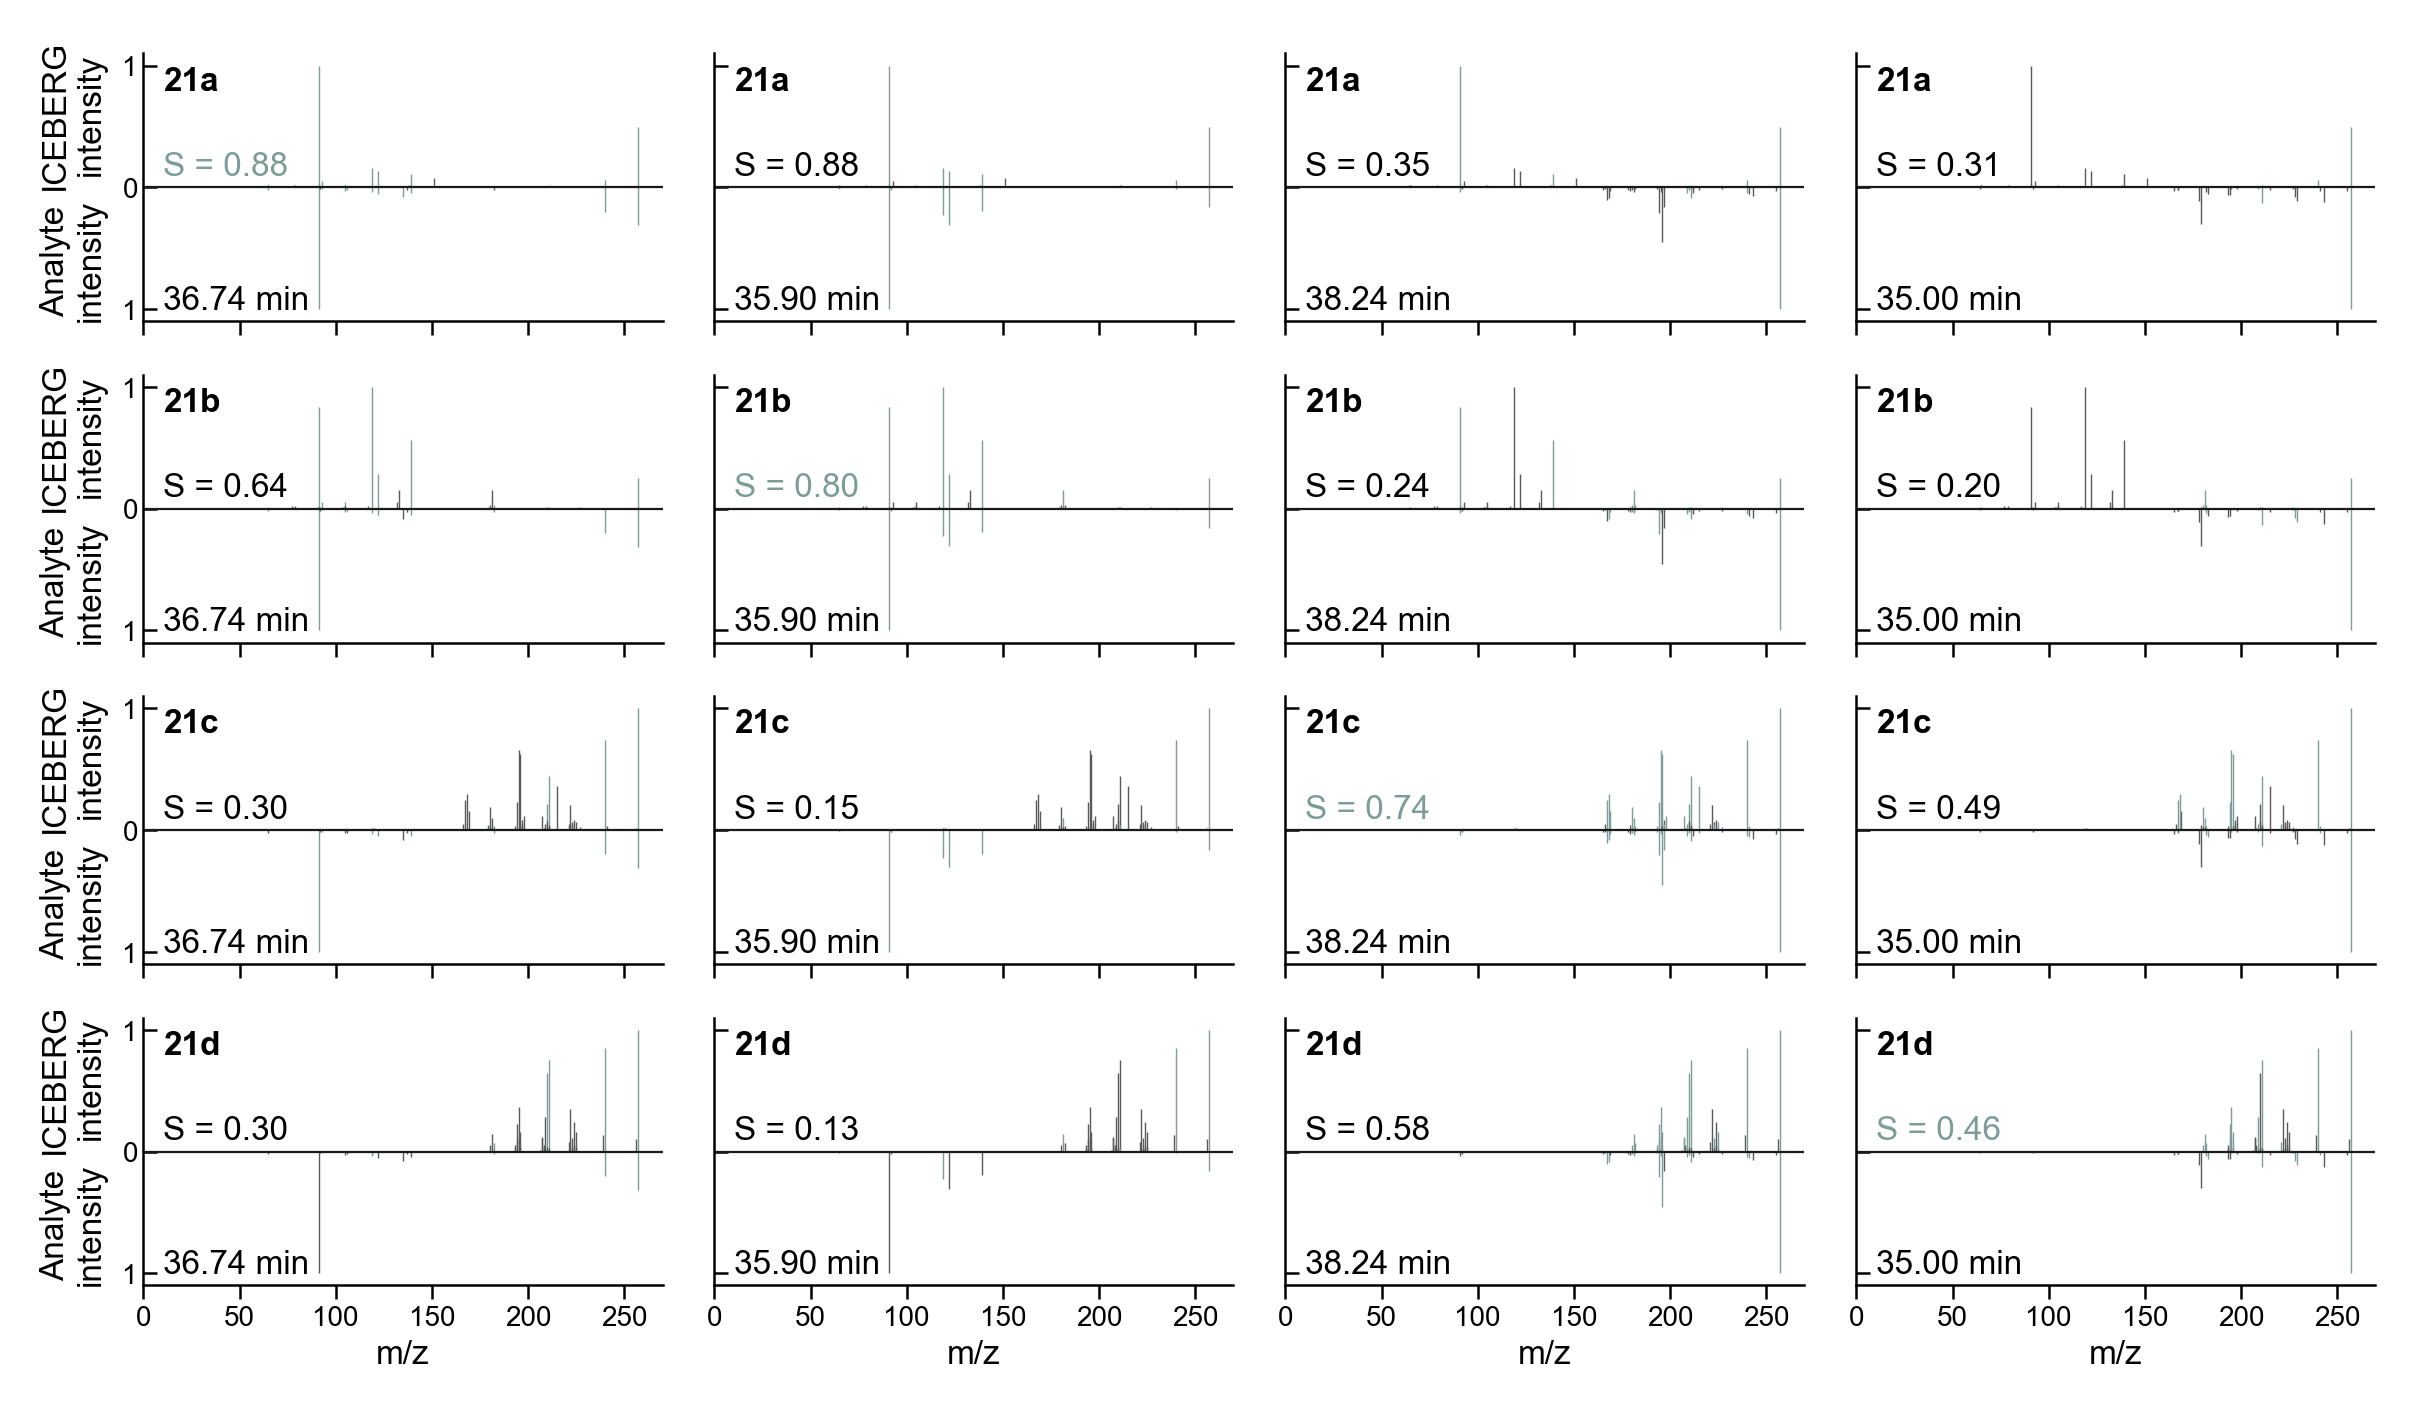

In [16]:
import itertools

all_smiles = ['C%12(CCCNC%13=CC=C(N(=O)=O)C=C%13)=CC=CC=C%12', 'CCC(NC6=CC=C(N(=O)=O)C=C6)C7=CC=CC=C7', 'CC(C)C%10=C(NC%11=CC=C(N(=O)=O)C=C%11)C=CC=C%10', 'CCC8=CC=CC(C)=C8NC9=CC=C(N(=O)=O)C=C9']
all_feat_ids = ['10385', '9978', '10917', '9718']
inp_mgf = '/home/roger/ms_collaborators/Bo-reaction-discovery/20250405_pool/all_nitro_and_iodo_20250411_sirius.mgf'


all_specs = common.parse_spectra_mgf(inp_mgf)
feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if (entry[0]['MSLEVEL'] == '2' and entry[0]['FEATURE_ID'] in all_feat_ids)
}
all_specs = [feat_id_to_specs[id] for id in all_feat_ids]

rt_map = {0: 36.74, 1: 35.90, 2: 38.24, 3: 35.00}

ent_matrix = np.zeros((len(all_smiles), len(all_specs)))
fig, axes = plt.subplots(len(all_smiles), len(all_specs), figsize=(1.8 * len(all_specs), 1. * len(all_smiles)), dpi=400)
for i, j in itertools.product(range(len(all_smiles)), range(len(all_specs))):
    ax = axes[i][j]
    entr_dist = visual_preds_compare(all_smiles[i], {'nan': all_specs[j]}, [30, 45, 60],
                         nce=True, explain_npeaks=0, merge_ces=True, step_collision_energy=True, real_spec_type='raw', axes=ax, ignore_precursor=False,
                         pred_label=f'ICEBERG\nintensity' if j == 0 else "", real_label=f'Analyte\nintensity' if j == 0 else "")
    ent_matrix[i][j] = 1 - entr_dist
    ax.text(257.1285/25, 0.8, f'21{chr(i + ord("a"))}', weight='bold')
    ax.text(257.1285/25, -1, f'{rt_map[j]:.2f} min')
    ax.set_title("")
    if i != len(all_smiles) - 1:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    if j != 0:
        ax.set_yticklabels([])

for i, j in itertools.product(range(len(all_smiles)), range(len(all_specs))):
    ax = axes[i][j]
    ax.text(257.1285/25, 0.1, f'S = {ent_matrix[i][j]:.2f}', color='#7C9D97' if assignment[i][j] else 'black')

plt.subplots_adjust(hspace=0.2, wspace=0.1)
plt.savefig('bh_pool_nitro.pdf', bbox_inches='tight')

# SI-3 body reaction

0.6214803949670933

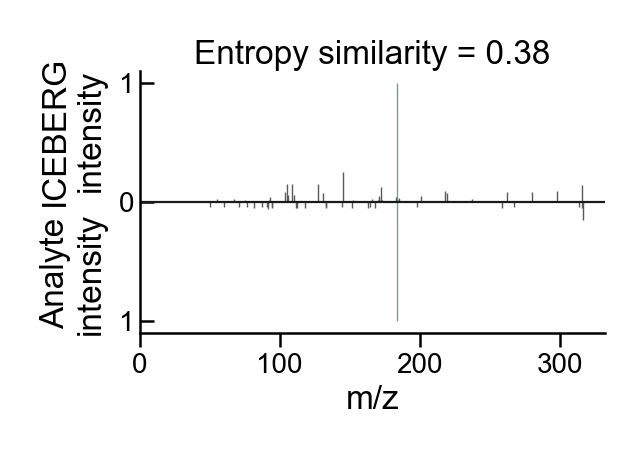

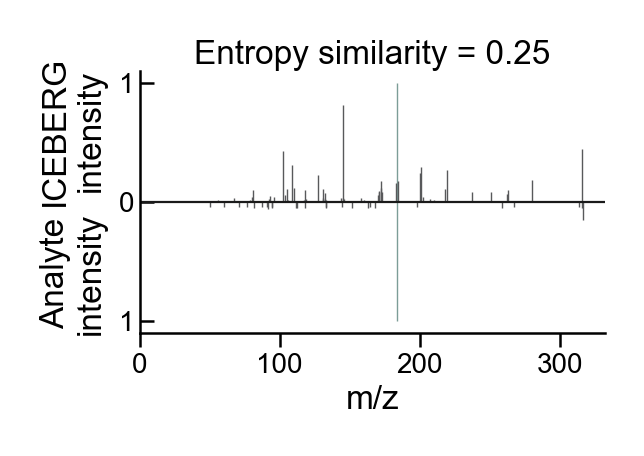

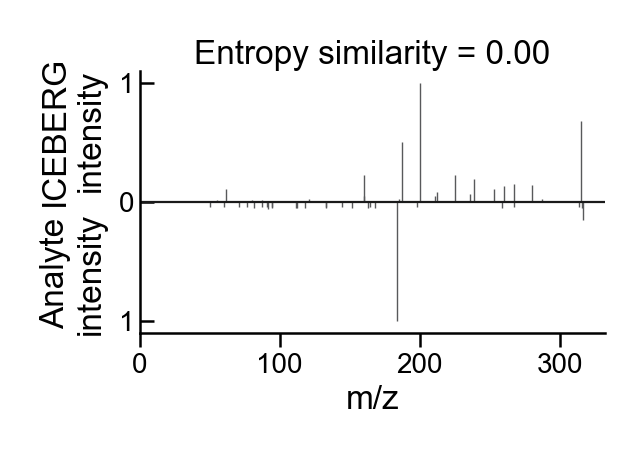

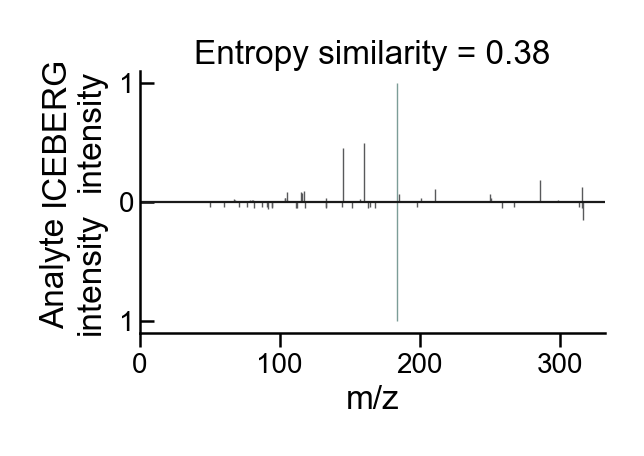

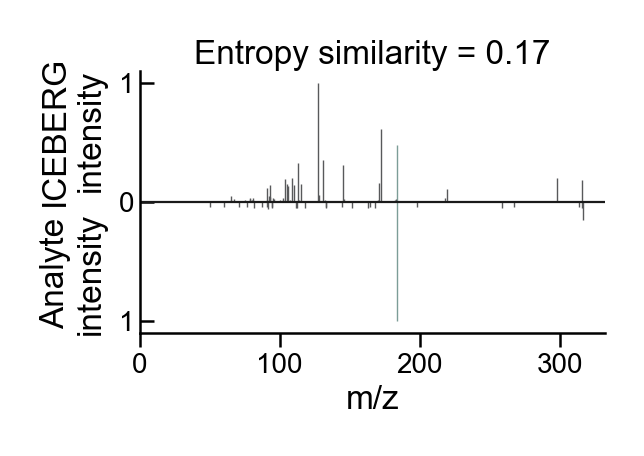

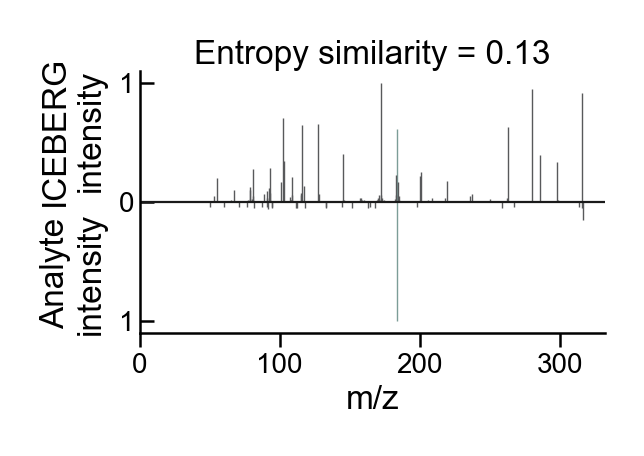

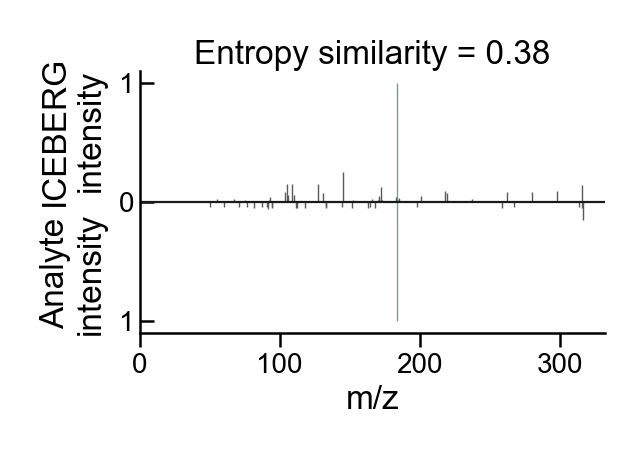

In [17]:
spec = """50.171917 4.781
60.195175 4.512
70.751877 4.574
76.727646 4.619
81.706345 4.924
87.020638 4.689
91.115021 4.732
91.95446 5.869
94.663925 5.567
94.799889 4.539
111.403877 4.859
112.383728 4.994
118.283005 5.016
133.291382 4.583
133.384552 4.922
144.246475 4.817
151.913071 5.518
163.321503 5.284
164.509781 4.467
168.044952 5.533
183.975714 100
198.012009 4.712
258.398071 5.272
267.455811 4.671
313.966309 4.709
315.991943 5.53
316.160583 15.308"""
spec = [row.split() for row in spec.split("\n")]
spec = {'nan': np.array([[float(row[0]), float(row[1])] for row in spec])}

visual_preds_compare(r'ClC(CCCC1)(CNC2=C(Br)C=CC=C2)C1=O', spec,
                     [30, 45, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='3body-1',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

visual_preds_compare(r'O=C1C(CCCC1CNC2=C(Br)C=CC=C2)Cl', spec,
                     [30, 45, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='3body-2',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

visual_preds_compare(r'ClC1CCCC=C1OCNC2=C(Br)C=CC=C2', spec,
                     [30, 45, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='3body-3',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

visual_preds_compare(r'ClC1CCCCC12OCN2C3=C(Br)C=CC=C3', spec,
                     [30, 45, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='3body-4',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

visual_preds_compare(r'OC1(CCCC=C1Cl)CNC2=C(Br)C=CC=C2', spec,
                     [30, 45, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='3body-5',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

visual_preds_compare(r'ClC1CCCC2COC12NC3=C(Br)C=CC=C3', spec,
                     [30, 45, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='3body-6',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')

visual_preds_compare(r'O=C1CCCCC1(CNC2=C(Br)C=CC=C2)Cl', spec,
                     [30, 45, 60], nce=True, merge_ces=True, step_collision_energy=True, explain_npeaks=0, real_spec_type='raw', name='3body-7',
                     pred_label='ICEBERG\nintensity', real_label='Analyte\nintensity')